We will perform dNdS using probabilities for single base substitutions (single nucleotide context)

Do we have patients with 2 mutations in a single gene?

General steps:
1. Get the probabilities for all 6 types of single base substitutions
   - C>A
   - C>G
   - C>T
   - T>A
   - T>C
   - T>G
2. 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import poisson
from scipy.stats import fisher_exact

In [6]:
# change working directory to project-2
if os.getcwd().split('/')[-1] != 'project-2':
    os.chdir('../../../')

# set paths
METADATA = 'data/raw/TCGA.BRCA.metadata.txt'
MUTATIONS = 'data/processed/TCGA.BRCA.mutations.qc1.txt'
DNDS = 'results/tables/dnds_simple_results.tsv'
CDS_LENGTHS = 'data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_lengths.tsv'

df_mut = pd.read_csv(MUTATIONS, sep='\t')
df_meta = pd.read_csv(METADATA, sep='\t')
df_dnds = pd.read_csv(DNDS, sep='\t')
df_cds = pd.read_csv(CDS_LENGTHS, sep='\t')

In [7]:
df_dnds = pd.merge(df_cds[['Hugo_Symbol','CDS_length']], df_dnds.drop(columns=['CDS_length']), on='Hugo_Symbol', how='inner')
df_dnds.head()

,Hugo_Symbol,CDS_length,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,synonymous_opportunity,nonsynonymous_opportunity,observed_nonsynonymous,dS,dN,dN/dS
0,A2M,4425,1,4,2,0,0,3082,10193,6,0.000324,0.000589,1.814186
1,A2ML1,4365,4,6,1,0,0,3006,10089,7,0.001331,0.000694,0.521409
2,AARS,2907,1,4,0,0,0,2014,6707,4,0.000497,0.000596,1.201133
3,AATK,4125,1,4,0,0,0,3147,9228,4,0.000318,0.000433,1.364109
4,ABCA1,6786,2,3,0,0,0,4612,15746,3,0.000434,0.000191,0.439350


In [8]:
# get overall by total mutation opportunities
num_mutations = len(df_mut)
overall_r = num_mutations / ((df_dnds.nonsynonymous_opportunity.sum() + df_dnds.synonymous_opportunity.sum()) * len(df_meta))
r = (df_dnds.synonymous.sum() + df_dnds.observed_nonsynonymous.sum())/((df_dnds.nonsynonymous_opportunity.sum() + df_dnds.synonymous_opportunity.sum()) * len(df_meta))

def poisson_pval_adj(x):
    """Adjusted p-value for observed nonsynonymous mutation count of the gene"""
    return 1 - poisson.cdf(x['observed_nonsynonymous']-1, x['synonymous']*x['nonsynonymous_opportunity']/x['synonymous_opportunity'])

def poisson_pval(x, r):
    """P-value for nonsynonymous mutation count of the gene"""
    return 1 - poisson.cdf(x['observed_nonsynonymous']-1, r*x['nonsynonymous_opportunity'])

In [9]:
df_dnds['poisson_pval'] = df_dnds.apply(lambda x: poisson_pval(x, r), axis=1)
df_dnds['poisson_pval_adj'] = df_dnds.apply(lambda x: poisson_pval_adj(x), axis=1)
df_dnds['poisson_pval_overall'] = df_dnds.apply(lambda x: poisson_pval(x, overall_r), axis=1)

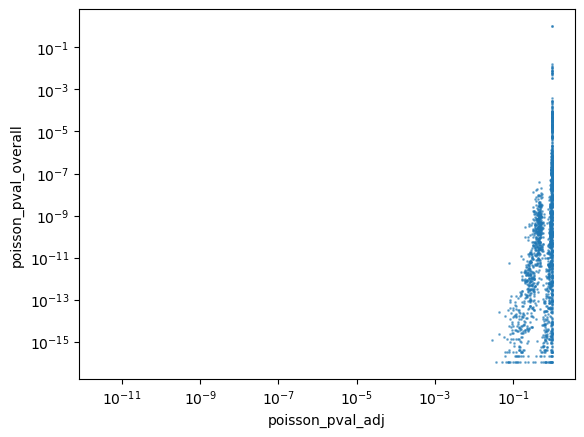

In [11]:
df_dnds.plot.scatter(x='poisson_pval_adj', y='poisson_pval_overall', alpha=0.5, s=1)
plt.xscale('log')
plt.yscale('log')

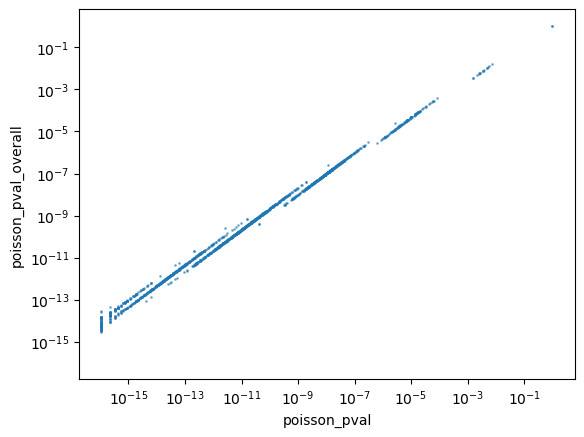

In [12]:
df_dnds.plot.scatter(x='poisson_pval', y='poisson_pval_overall', alpha=0.5, s=1)
plt.xscale('log')
plt.yscale('log')

,Hugo_Symbol,CDS_length,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,synonymous_opportunity,nonsynonymous_opportunity,observed_nonsynonymous,dS,dN,dN/dS,poisson_pval,poisson_pval_adj,poisson_pval_overall
0,A2M,4425,1,4,2,0,0,3082,10193,6,0.000324,0.000589,1.814186,2.220446e-16,0.117999,2.053913e-14


In [22]:
def fisher_pval(x):
    """P-value for the Fisher's exact test"""
    table = [[x['observed_nonsynonymous'], x['nonsynonymous_opportunity'] - x['observed_nonsynonymous']], 
             [x['synonymous'], x['synonymous_opportunity'] - x['synonymous']]
             ]
    odds, pval = fisher_exact(table, alternative='greater')
    return pd.Series({'fisher_odds': odds, 'fisher_pval': pval})

df_dnds[['fisher_odds', 'fisher_pval']] = df_dnds.apply(fisher_pval, axis=1)

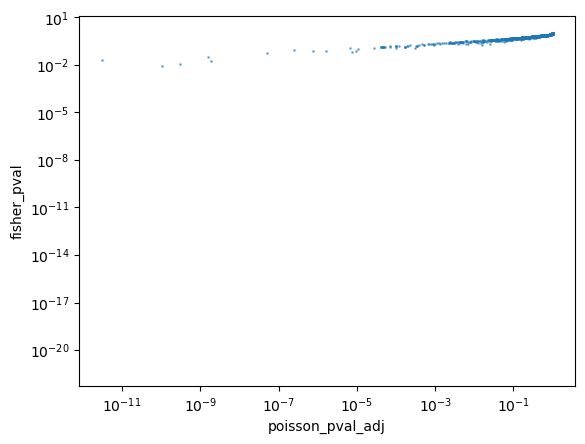

In [23]:
df_dnds.plot.scatter(x='poisson_pval_adj', y='fisher_pval', alpha=0.5, s=1)
plt.xscale('log')
plt.yscale('log')

In [24]:
df_dnds.head()

,Hugo_Symbol,CDS_length,synonymous,Missense_Mutation,Nonsense_Mutation,Translation_Start_Site,Nonstop_Mutation,synonymous_opportunity,nonsynonymous_opportunity,observed_nonsynonymous,dS,dN,dN/dS,poisson_pval,poisson_pval_adj,poisson_pval_overall,fisher_odds,fisher_pval
0,A2M,4425,1,4,2,0,0,3082,10193,6,0.000324,0.000589,1.814186,2.220446e-16,0.117999,2.053913e-14,1.814666,0.490357
1,A2ML1,4365,4,6,1,0,0,3006,10089,7,0.001331,0.000694,0.521409,0.000000e+00,0.979865,0.000000e+00,0.521077,0.915597
2,AARS,2907,1,4,0,0,0,2014,6707,4,0.000497,0.000596,1.201133,2.168221e-11,0.426321,4.713553e-10,1.201253,0.672980
3,AATK,4125,1,4,0,0,0,3147,9228,4,0.000318,0.000433,1.364109,7.758838e-11,0.337608,1.683901e-09,1.364267,0.623735
4,ABCA1,6786,2,3,0,0,0,4612,15746,3,0.000434,0.000191,0.439350,2.336694e-07,0.966283,2.337431e-06,0.439243,0.919686
